In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
import datetime
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# The below commented lines are for ResNet and VGG16
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras.applications import VGG16
# from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
# Set up the GPU memory size to avoid the out-of-memory error
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 6GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# If using ResNet and VGG16, please confirm img_width, img_height = 224, 224
img_width, img_height = 299, 299
NUM_EPOCHS = 10
batchsize = 50
num_train_images = 3200
num_val_images = 400

# For ResNet, InceptionV3 will be replaced by ResNet50, for VGG, InceptionV3 will be replaced by VGG16
base_model = InceptionV3(weights='imagenet', 
                         include_top=False, 
                         input_shape=(img_height, img_width, 3))

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/home/mike/Documents/keras_inception_v3/furniture_pictures/train'


train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batchsize)

Found 3200 images belonging to 5 classes.


In [6]:
from keras.preprocessing.image import ImageDataGenerator

val_dir = '/home/mike/Documents/keras_inception_v3/furniture_pictures/val'


val_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True)

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                target_size=(img_height, img_width), 
                                                batch_size=batchsize)

Found 400 images belonging to 5 classes.


In [7]:
# Build the model 
def build_final_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    final_model = Model(inputs=base_model.input, outputs=predictions)

    return final_model

class_list = ["bed", "chair", "sofa", "swivelchair", "table"]
FC_LAYERS = [1024, 1024]
dropout = 0.3

final_model = build_final_model(base_model, 
                                dropout=dropout, 
                                fc_layers=FC_LAYERS, 
                                num_classes=len(class_list))

In [8]:
# Compile the model 
adam = Adam(lr=0.00001)
final_model.compile(adam, 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

In [9]:
# Start Tensorboard --logdir logs/fit
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback_list = [tensorboard_callback]

In [10]:
# Train the model 
history = final_model.fit(train_generator,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=num_train_images // batchsize,
                          validation_data=val_generator, 
                          validation_steps=num_val_images // batchsize,
                          callbacks=callback_list)

Epoch 1/10
64/64 [==============================] - 76s 1s/step - loss: 1.5058 - accuracy: 0.3475 - val_loss: 1.2779 - val_accuracy: 0.6650
Epoch 2/10
64/64 [==============================] - 68s 1s/step - loss: 1.1913 - accuracy: 0.5994 - val_loss: 0.9689 - val_accuracy: 0.7675
Epoch 3/10
64/64 [==============================] - 68s 1s/step - loss: 0.9366 - accuracy: 0.7228 - val_loss: 0.7471 - val_accuracy: 0.8000
Epoch 4/10
64/64 [==============================] - 68s 1s/step - loss: 0.7813 - accuracy: 0.7544 - val_loss: 0.6281 - val_accuracy: 0.8375
Epoch 5/10
64/64 [==============================] - 68s 1s/step - loss: 0.6689 - accuracy: 0.7778 - val_loss: 0.5242 - val_accuracy: 0.8525
Epoch 6/10
64/64 [==============================] - 68s 1s/step - loss: 0.6058 - accuracy: 0.7984 - val_loss: 0.5135 - val_accuracy: 0.8400
Epoch 7/10
64/64 [==============================] - 68s 1s/step - loss: 0.5328 - accuracy: 0.8291 - val_loss: 0.4353 - val_accuracy: 0.8600
Epoch 8/10
64/64 [==

In [11]:
# Show the graph
%tensorboard --logdir logs/fit

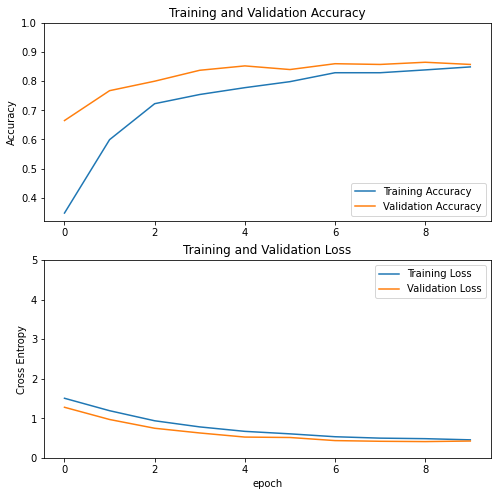

In [12]:
# Give the graph 
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
# Preprocess the images
from keras.preprocessing import image
import numpy as np
# the below path shows the full path for uploaded image, adjust it for your specific path
img_path = '/home/mike/Documents/keras_inception_v3/furniture_pictures/train/bed/00000002.jpg'
#img_path ='/home/krish/visual_search/furniture-detector/img/train/chair/00000009.jpg'
#img_path ='/home/krish/visual_search/furniture-detector/img/train/sofa/00000016.jpg'
img = image.load_img(img_path, target_size=(img_width, img_height))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data1 = preprocess_input(img_data)

pretrained_feature = final_model.predict(img_data,verbose=0)
pretrained_feature_np = np.array(pretrained_feature)
pretrained_feature1D = pretrained_feature_np.flatten()

pretrained_feature_base = base_model.predict(img_data1)
pretrained_feature_np_base = np.array(pretrained_feature_base)
pretrained_feature1D_base = pretrained_feature_np_base.flatten()


print (pretrained_feature1D)
y_prob = final_model.predict(img_data)

y_classes = y_prob.argmax(axis=-1)

print(y_classes)

[0.6417312  0.01883547 0.29879382 0.02201265 0.01862694]
[0]


In [14]:
# Give both the Eucledian distance and the cosine similarity
import os
from scipy.spatial import distance as dist
from sklearn.metrics.pairwise import cosine_similarity

# Below shows the full path for test images, adjust it for your specific path
if y_classes == [0]:
    path = '/home/mike/Documents/keras_inception_v3/furniture_pictures/val/bed'
elif y_classes == [1]:
    path = '/home/mike/Documents/keras_inception_v3/furniture_pictures/val/chair'
else:
    path = '/home/mike/Documents/keras_inception_v3/furniture_pictures/val/sofa'
    
mindist=10000
maxcosine =0
i=0

for filename in os.listdir(path):
    image_train = os.path.join(path, filename)
    i +=1
    imgtrain = image.load_img(image_train, target_size=(img_width, img_height))
    img_data_train = image.img_to_array(imgtrain)
    img_data_train = np.expand_dims(img_data_train, axis=0)
    img_data_train = preprocess_input(img_data_train)

    pretrained_feature_train = base_model.predict(img_data_train)
    pretrained_feature_np_train = np.array(pretrained_feature_train)
    pretrained_feature_train1D = pretrained_feature_np_train.flatten()
    eucldist = dist.euclidean(pretrained_feature1D_base,pretrained_feature_train1D)
    
    if mindist > eucldist:
        mindist=eucldist
        minfilename = filename
    #print (vgg16_feature_np)
    
    dot_product = np.dot(pretrained_feature1D_base,pretrained_feature_train1D)#normalize the results, to achieve similarity measures independant #of the scale of the vectors
    norm_Y = np.linalg.norm(pretrained_feature1D_base)
    norm_X = np.linalg.norm(pretrained_feature_train1D)
    cosine_similarity = dot_product / (norm_X * norm_Y)
    
    if maxcosine < cosine_similarity:
        maxcosine=cosine_similarity
        cosfilename = filename
    
    
    print ("%s filename %f euclediandist %f cosine_similarity" %(filename,eucldist,cosine_similarity))
    print ("%s minfilename %f mineuclediandist %s cosfilename %f maxcosinesimilarity" %(minfilename,mindist, cosfilename, maxcosine))

00000500.jpg filename 208.793930 euclediandist 0.508606 cosine_similarity
00000500.jpg minfilename 208.793930 mineuclediandist 00000500.jpg cosfilename 0.508606 maxcosinesimilarity
00000567.jpg filename 243.576691 euclediandist 0.408580 cosine_similarity
00000500.jpg minfilename 208.793930 mineuclediandist 00000500.jpg cosfilename 0.508606 maxcosinesimilarity
00000568.jpg filename 296.681213 euclediandist 0.243750 cosine_similarity
00000500.jpg minfilename 208.793930 mineuclediandist 00000500.jpg cosfilename 0.508606 maxcosinesimilarity
00000270.jpg filename 168.452026 euclediandist 0.648297 cosine_similarity
00000270.jpg minfilename 168.452026 mineuclediandist 00000270.jpg cosfilename 0.648297 maxcosinesimilarity
00000315.jpg filename 254.784927 euclediandist 0.423681 cosine_similarity
00000270.jpg minfilename 168.452026 mineuclediandist 00000270.jpg cosfilename 0.648297 maxcosinesimilarity
00000044.jpg filename 160.667191 euclediandist 0.693461 cosine_similarity
00000044.jpg minfilen

00000269.jpg filename 245.043671 euclediandist 0.445901 cosine_similarity
00000044.jpg minfilename 160.667191 mineuclediandist 00000044.jpg cosfilename 0.693461 maxcosinesimilarity
00000441.jpg filename 319.594482 euclediandist 0.256879 cosine_similarity
00000044.jpg minfilename 160.667191 mineuclediandist 00000044.jpg cosfilename 0.693461 maxcosinesimilarity
00000164.jpg filename 253.050613 euclediandist 0.370395 cosine_similarity
00000044.jpg minfilename 160.667191 mineuclediandist 00000044.jpg cosfilename 0.693461 maxcosinesimilarity
00000569.jpg filename 215.948090 euclediandist 0.512888 cosine_similarity
00000044.jpg minfilename 160.667191 mineuclediandist 00000044.jpg cosfilename 0.693461 maxcosinesimilarity
00000361.jpg filename 319.027069 euclediandist 0.245487 cosine_similarity
00000044.jpg minfilename 160.667191 mineuclediandist 00000044.jpg cosfilename 0.693461 maxcosinesimilarity
00000842.jpg filename 207.839371 euclediandist 0.482259 cosine_similarity
00000044.jpg minfilen

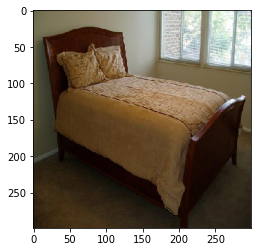

In [15]:
# Plot the graph 
import matplotlib.pyplot as plt
%matplotlib inline
image_result = os.path.join(path, minfilename)
imgresult = image.load_img(image_train, target_size=(224, 224))
plt.imshow(img)

Text(0.5, 1.0, 'Cosine_Similarity 0.6934611')

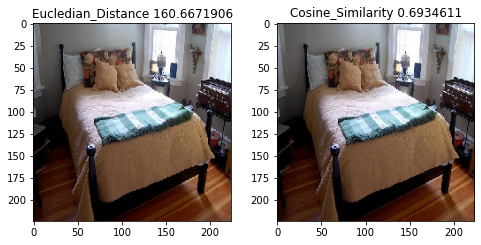

In [16]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2,2,1)
image_result1 = os.path.join(path, minfilename)
imgresult1 = image.load_img(image_result1, target_size=(224, 224))
plt.imshow(imgresult1)
eucledian5d ="%.7f" % mindist
plt.title("Eucledian_Distance " + str(eucledian5d))

fig.add_subplot(2,2,2)
image_result2 = os.path.join(path, cosfilename)
imgresult2 = image.load_img(image_result2, target_size=(224, 224))
plt.imshow(imgresult2)
cosine5d ="%.7f" % maxcosine
plt.title("Cosine_Similarity " + str(cosine5d))